In [1]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))
suppressPackageStartupMessages(library(org.Mm.eg.db))
library(GSA)
library(forcats)
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'Block HSIC Lasso, B = 50' = '#df65b0',
             'Block HSIC Lasso, B = 20' = '#e7298a', 'Block HSIC Lasso, B = 10' = '#ce1256',
             'Block HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('Block HSIC Lasso, B = 20',
             'mRMR', 'Block HSIC Lasso, B = 10',
             'LARS', 'Block HSIC Lasso, B = 5',  'Raw')
palette_yn = c("Yes" = "#91cf60", "No" = "#d6604d")
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(label) {
    
    read_tsv(paste0('../results/single_cell/', label, '_prediction.tsv'), col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = ifelse(grepl('-B=', model), paste('Block', model), model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy, na.rm = T) / sqrt(ended), accuracy = mean(accuracy, na.rm = T) ) %>%
        ungroup %>%
        mutate(label = paste(tools::toTitleCase(label), 'et al.'))

}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ readr   1.3.1
✔ tibble  2.0.1     ✔ purrr   0.3.0
✔ tidyr   0.8.2     ✔ dplyr   0.7.8
✔ ggplot2 3.1.0     ✔ stringr 1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::collapse()   masks IRanges::collapse()
✖ dplyr::combine()    masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::desc()       masks IRanges::desc()
✖ tidyr::expand()     masks S4Vectors::expand()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::first()      masks S4Vectors::first()
✖ purrr::flatten()    masks jsonlite::flatten()
✖ dplyr::lag()        masks stats::lag()
✖ ggplot2::Position() masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()     masks IRanges::reduce()
✖ dplyr::rename()     masks S4Vectors::rename()
✖ dplyr::select()     masks AnnotationDbi::select()
✖ purrr::simplify()   masks clusterProfiler::simplify()
✖ dplyr::slice()      masks I

# Benchmark

In [2]:
sc <- bind_rows(summarize_benchmark('haber'), summarize_benchmark('habib'), summarize_benchmark('villani'))

raw <- filter(sc, model == 'Raw')
sc <- filter(sc, model != 'Raw')

We analyzed the following datasets:

- [Haber et al.](https://portals.broadinstitute.org/single_cell/study/small-intestinal-epithelium): 15,972 genes x 7,216 cells x 19 cell types
- [Habib et al.](https://portals.broadinstitute.org/single_cell/study/-single-nucleus-rna-seq-of-cell-diversity-in-the-adult-mouse-hippocampus-snuc-seq): 25,393 genes x 13,302 cells x 8 cell types
- [Villani et al.](https://portals.broadinstitute.org/single_cell/study/atlas-of-human-blood-dendritic-cells-and-monocytes): 23,395 genes x 1,140 cells x 10 cell types

They were imputed with MAGIC, then followed a feature selection step + RF classifier.

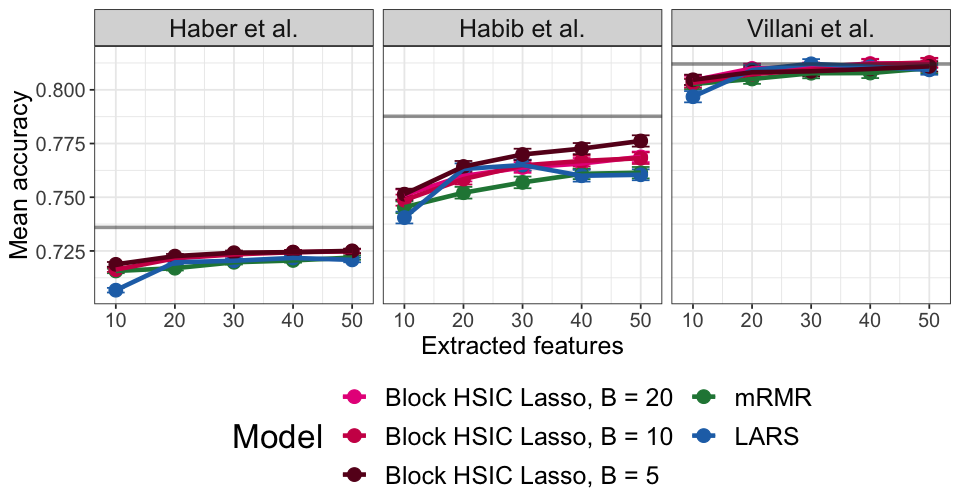

In [3]:
options(repr.plot.width=8, repr.plot.height=4.2)

ggplot(sc, aes(x = selected, y = accuracy, color = model)) +
    geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
    geom_point(size = 3.5) +
    geom_line(size = 1.3) +
    geom_hline(data = raw, aes(yintercept = accuracy), 
               colour = 'gray20', alpha = 0.5, size = 1) + 
    theme_bw() +
    theme(legend.position = 'bottom',
          axis.text = element_text(size = 12),
          axis.title = element_text(size = 15),
          strip.text.x = element_text(size = 15),
          legend.text = element_text(size = 15),
          legend.title = element_text(size = 20)) +
    labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
    scale_color_manual(values = palette) +
    facet_grid(. ~ label) +
    guides(color = guide_legend(nrow = 3, byrow = TRUE, keyheight=0.1))

Warning message:
“`data_frame()` is deprecated, use `tibble()`.
This warning is displayed once per session.”

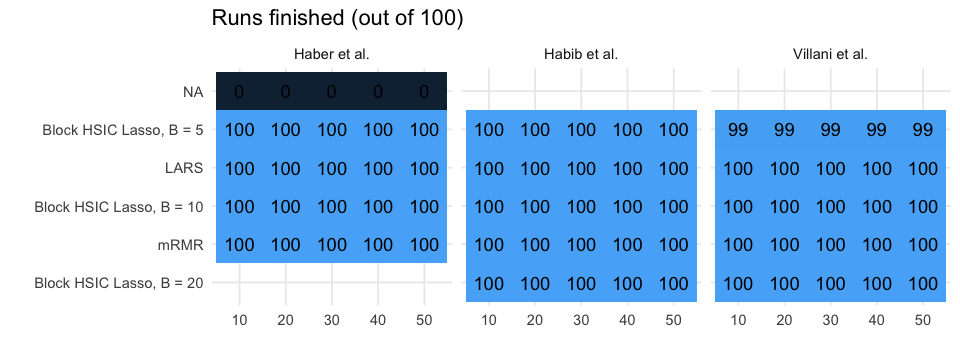

In [4]:
options(repr.plot.width=8, repr.plot.height=3)
sc %>%
    bind_rows(data_frame(model = factor('HSIC Lasso, B = 20', levels = methods),
                         label = 'Haber et al.', ended = 0, selected = seq(10, 50, 10))) %>%
    ggplot(aes(x = model, y = factor(selected), fill = ended, label = ended)) +
        geom_tile() +
        geom_text() +
        theme_minimal() +
        theme(legend.position = 'none') +
        labs(x = '', y = '', title = 'Runs finished (out of 100)') +
        coord_flip() +
        facet_grid(. ~ label)

# Analysis of the datasets

In [5]:
pathways_mouse <- suppressPackageStartupMessages(
    read.gmt(gmtfile = "../data/Mus_musculus_GSEA_GO_sets_bp_symbols_highquality_April_2015.gmt")) %>%
    mutate(ont = gsub('\\([0-9]\\)', '', ont),
           gene = tools::toTitleCase(tolower(gene)),
           ont = tools::toTitleCase(ont),
           ont = gsub('_', ' ', ont))
pathways_human <- read.gmt(gmtfile = "../data/c2.cp.v6.2.symbols.gmt") %>%
    mutate(ont = gsub('\\([0-9]\\)', '', ont),
           ont = gsub('REACTOME_', '', ont),
           ont = gsub('KEGG_', '', ont),
           ont = gsub('PID_', '', ont),
           ont = tools::toTitleCase(ont),
           ont = gsub('_', ' ', ont))

In [6]:
read_predictions <- function(label) {
    
    x <- bind_rows(read_tsv(paste0('../results/single_cell/', label, '_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>% mutate(Method = 'HSIC Lasso, B = 20') %>% head(20),
                   read_tsv(paste0('../results/single_cell/', label, '_lars_C=20.txt'), 
                            col_names = 'Gene', col_types = 'c') %>% mutate(Method = 'LARS'),
                   read_tsv(paste0('../results/single_cell/', label, '_mrmr_C=20.txt'), 
                            col_names = 'Gene', col_types = 'c') %>% mutate(Method = 'mRMR'))
    
    # number of features selected
    print(table(x$Method))

    # number of features selected by more than one method
    x %>%
        group_by(Gene) %>%
        summarize(n = as.character(n())) %>%
        filter(n > 1) %>%
        print
    
    return(x)
    
}

gene2pathway <- function(genes, pathways) {
    
    rank <- inner_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        group_by(ont) %>%
        summarize(n = length(unique(Method)))

    left_join(genes, pathways, by = c('Gene' = 'gene')) %>%
        left_join(rank, by = "ont") %>%
        arrange(-n) %>%
        group_by(Gene, Method) %>%
        summarize(ont = head(ont, 1)) %>%
        ungroup
    
}

plot_pathways <- function(genes, pathways) {
    
    gene2pathway(genes, pathways) %>%
        filter(!is.na(ont)) %>%
        group_by(ont) %>%
        filter(length(unique(Method)) >= 2) %>%
        ungroup %>%
        ggplot(aes(fct_infreq(ont), fill = Method)) +
            geom_bar() + 
            theme(axis.text.x = element_text(angle = 90, hjust = 1),
                  legend.position = 'bottom') +
            labs(x = '', y = 'Count') +
            coord_flip() +
            scale_fill_manual(values = palette)
    
}

We run our three approaches on the different datasets to analyze the retrieved biomarkers.

## Haber *et al.*: mouse intestine

In [7]:
haber <- read_predictions('haber')


HSIC Lasso, B = 20               LARS               mRMR 
                20                 18                 20 
# A tibble: 1 x 2
  Gene  n    
  <chr> <chr>
1 Krt18 2    


Only Krt18 is selected by more than one method.

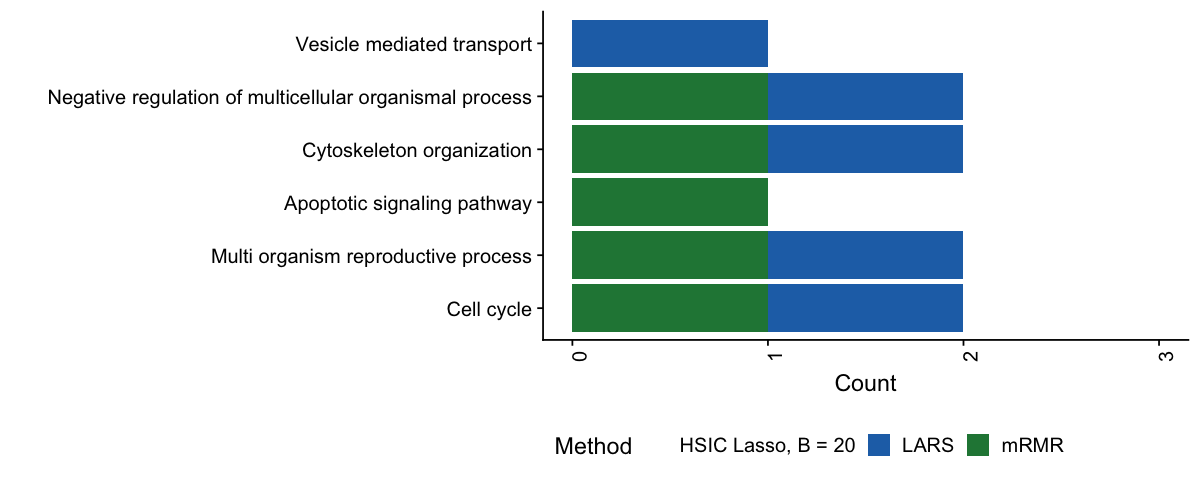

In [8]:
rank <- inner_join(haber, pathways_mouse, by = c('Gene' = 'gene')) %>%
    group_by(ont) %>%
    summarize(n = length(unique(Method)))

options(repr.plot.width=10, repr.plot.height=4)
plot_pathways(haber, pathways_mouse)

We associate one GO Term (Biological process) to each gene, and see if different methods are selecting related genes. We find 13 biological functions that are selected by different methods.

In [9]:
enrichGO(gene    = unique(haber$Gene),
         OrgDb   = org.Mm.eg.db,
         keyType = 'SYMBOL') %>%
    as.tibble

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count


We found no enriched GO terms. This makes sense, since we are looking for a non-redundant subset of the genes.

## Habib *et al.*: mouse hippocampus

In [10]:
habib <- read_predictions('habib')


HSIC Lasso, B = 20               LARS               mRMR 
                20                 16                 20 
# A tibble: 0 x 2
# … with 2 variables: Gene <chr>, n <chr>


No gene is selected by more than one method.

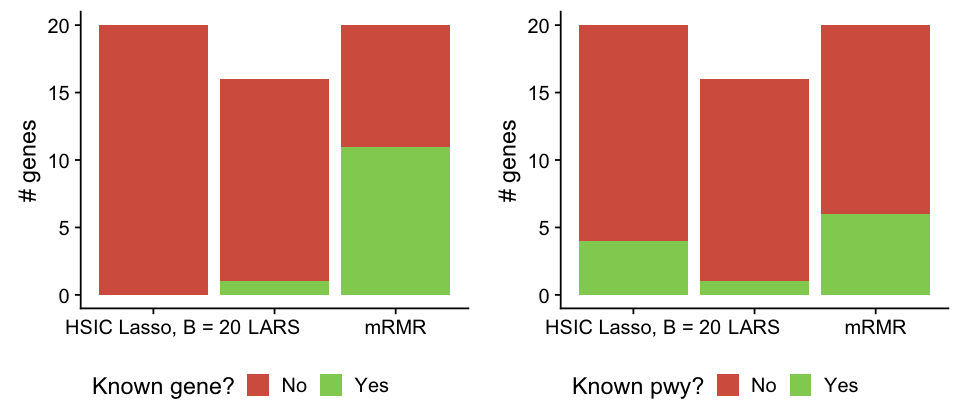

In [11]:
markers <- c(read_tsv('~/data/single_cell/habib/Major_cell_types_marker_genes.txt',
                      col_types = 'cddddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/Glia_subcluster_marker_genes.txt',
                         col_types = 'cdddddd') %>% .$`GENE NAMES`,
             read_tsv('~/data/single_cell/habib/GABAergic_edit_subcluster_marker_gene.txt',
                         col_types = 'cdddddddd') %>% .$`GENE NAMES`)

markers_pwy <- data_frame(Gene = markers, Method = 'Known genes') %>%
    gene2pathway(pathways_mouse) %>%
    .$ont %>%
    unique %>%
    na.omit

known_genes <- habib %>% 
    mutate(known_gene = ifelse(Gene %in% markers, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_gene)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known gene?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

known_pwy <- gene2pathway(habib, pathways_mouse) %>%
    mutate(known_pwy = ifelse(ont %in% markers_pwy, 'Yes', 'No')) %>%
    ggplot(aes(x = Method, fill = known_pwy)) +
        geom_bar() +
        scale_fill_manual(values = palette_yn) +
        labs(x = '', y = '# genes', fill = 'Known pwy?') +
        theme(legend.position = 'bottom', 
              axis.title.x = element_blank())

options(repr.plot.width=8, repr.plot.height=3.5)
plot_grid(known_genes, known_pwy)

For this dataset, the authors provided a list of 1,669 genes that are known to be different among the cell subpopulations. We checked which method was selecting more of them. Interestingly, almost half of mRMR selected features intersects with this list.

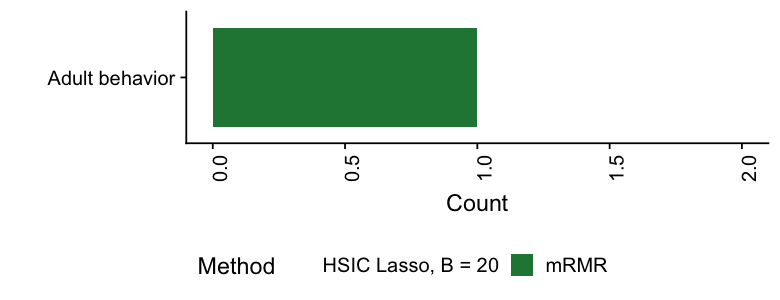

In [12]:
options(repr.plot.width=6.5, repr.plot.height=2.5)
plot_pathways(habib, pathways_mouse)

In [13]:
filter(habib, Method == 'HSIC Lasso, B = 20') %>%
    mutate(ranking = seq(1, n())) %>%
    gene2pathway(pathways_mouse) %>%
        filter(!is.na(ont))

Gene,Method,ont
Cubn,"HSIC Lasso, B = 20",Endocytosis
Klhl1,"HSIC Lasso, B = 20",Adult behavior
Otp,"HSIC Lasso, B = 20",Brain development
Pou3f1,"HSIC Lasso, B = 20",Schwann cell development


As before, we aggregated genes into pathways, finding 12 biological processes affected by several genes. In this case, the GO terms are easily interpretable, as many of them are related to brain development and signalling. It is remarkable that despite HSIC Lasso retrieved only one of the known markers, it retrieved some others that are involved in known brain functions, opening the doors to the discovery of new biomarkers.

In [14]:
enrichGO(gene    = unique(habib$Gene),
         OrgDb   = org.Mm.eg.db,
         keyType = 'SYMBOL') %>%
    as.tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count


In [15]:
filter(habib, Method == 'HSIC Lasso, B = 20')

Gene,Method
Gm15127,"HSIC Lasso, B = 20"
Hk1os,"HSIC Lasso, B = 20"
Klhl1,"HSIC Lasso, B = 20"
Mir670,"HSIC Lasso, B = 20"
Pou3f1,"HSIC Lasso, B = 20"
Lyzl6,"HSIC Lasso, B = 20"
Spaca4,"HSIC Lasso, B = 20"
Gm28040,"HSIC Lasso, B = 20"
Tmem45b,"HSIC Lasso, B = 20"
Igkv1-88,"HSIC Lasso, B = 20"


## Villani *et al.*: human blood

In [16]:
villani <- bind_rows(read_tsv(paste0('../results/single_cell/villani_hsic_lasso_C=50_SELECT=50_M=3_B=10.txt'), 
                            col_names = 'Gene', col_types = 'c') %>%
                   mutate(Method = 'HSIC Lasso, B = 20') %>% head(n = 20),
                   read_tsv('../results/single_cell/villani_lars_C=50.txt', 
                            col_names = 'Gene', col_types = 'c') %>%
                   mutate(Method = 'LARS') %>% head(n = 20))

table(villani$Method)


HSIC Lasso, B = 20               LARS 
                20                 20 

In the Villani dataset we couldn't apply mRMR as it crashes. There are no genes shared by different techniques.

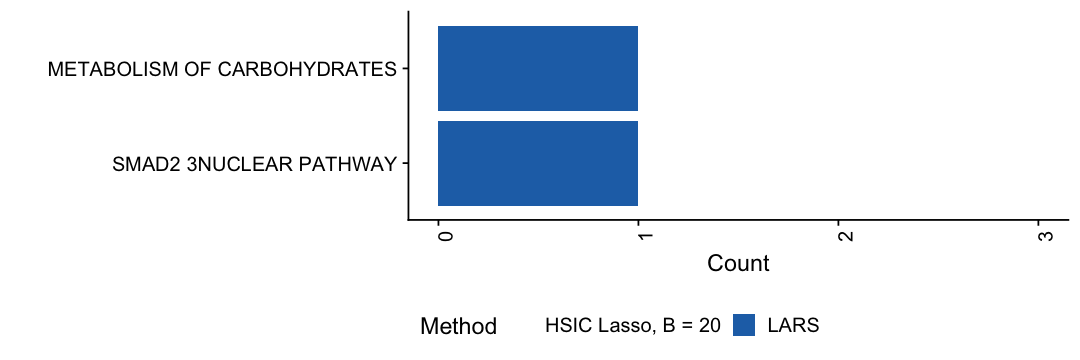

In [17]:
options(repr.plot.width=9, repr.plot.height=3)
plot_pathways(villani, pathways_human)

In [18]:
enrichGO(gene    = unique(villani$Gene),
         OrgDb   = org.Hs.eg.db,
         keyType = 'SYMBOL') %>%
    as.tibble

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
